# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [3]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [4]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [5]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [6]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [7]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [8]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [9]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [10]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [11]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [12]:
# don't shuffle  

"""import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(X, y, seed = 90)"""

'import random \ndef shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(X, y, seed = 90)'

In [13]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [14]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

    return model

In [15]:
original_X = X
original_Y = y 

In [16]:
"""def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(original_X, original_Y, seed=65)"""

'def shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(original_X, original_Y, seed=65)'

2021-11-02 21:52:21.852447: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 21:52:22.639432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75
3/3 [==============================] - 1s 148ms/step - loss: 0.7018 - accuracy: 0.6375 - precision: 0.6000 - recall: 0.8250 - val_loss: 0.6766 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6509 - accuracy: 0.6625 - precision: 0.8095 - recall: 0.4250 - val_loss: 0.6668 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6151 - accuracy: 0.7500 - precision: 0.7778 - recall: 0.7000 - val_loss: 0.6658 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 155ms/step - loss: 0.5947 - accuracy: 0.7125 - precision: 0.6889 - recall: 0.7750 - val_loss: 0.6026 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 156ms/step - loss: 0.5859 - accuracy: 0.7500 - precision: 0

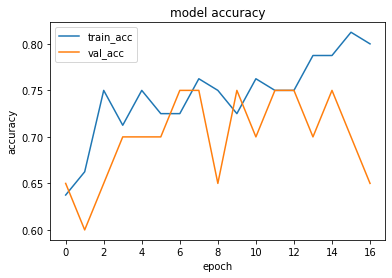

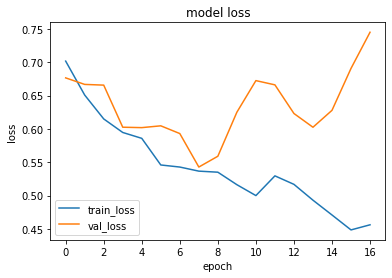

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
1it [00:00, 2803.68it/s]


prediction for video armflapping_1.mov is [[0.5373468]]


1it [00:00, 11244.78it/s]


prediction for video armflapping_3.mov is [[0.6215798]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.6942738]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.43459314]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.38047713]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.37478334]]
Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6950 - accuracy: 0.4875 - precision: 0.4889 - recall: 0.5500 - val_loss: 0.7338 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6526 - accuracy: 0.6000 - precision: 0.6333 - recall: 0.4750 - val_loss: 0.5967 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 178ms/step - loss: 0.6394 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.5830 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 206ms/step - loss: 0.6028 - accuracy: 0.7625 - precision: 0.7234 - recall: 0.8500 - val_loss: 0.6040 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0

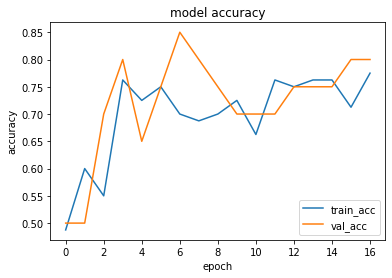

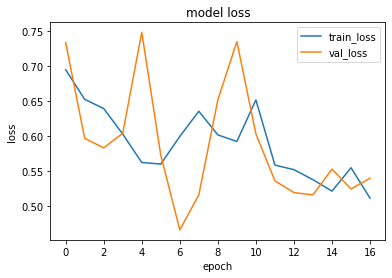

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.52503073]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_3.mov is [[0.49418107]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.56381935]]


1it [00:00, 12826.62it/s]


prediction for video control_1.mov is [[0.32416224]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.2811405]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.27789006]]
Epoch 1/75
3/3 [==============================] - 1s 186ms/step - loss: 0.6732 - accuracy: 0.6125 - precision: 0.6154 - recall: 0.6000 - val_loss: 0.7631 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6490 - accuracy: 0.6250 - precision: 0.5806 - recall: 0.9000 - val_loss: 0.6946 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 183ms/step - loss: 0.6845 - accuracy: 0.6000 - precision: 0.7000 - recall: 0.3500 - val_loss: 0.6928 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6182 - accuracy: 0.7250 - precision: 0.7647 - recall: 0.6500 - val_loss: 0.6923 - val_accuracy: 0.5500 - val_precision: 0.5714 - val_recall: 0.4000
Epoch 5/75
3/3 [==============================] - 0s 184ms/

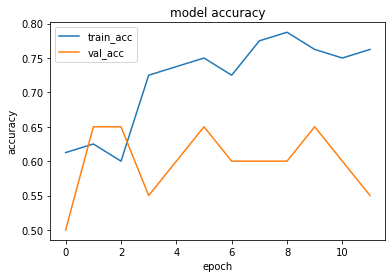

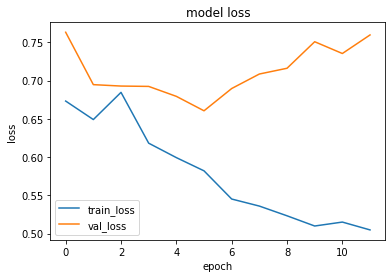

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.3280661]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.29454815]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.37247455]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.3081508]]


1it [00:00, 9776.93it/s]


prediction for video control_2.mov is [[0.30373675]]


1it [00:00, 12945.38it/s]


prediction for video control_3.mov is [[0.30182606]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6723 - accuracy: 0.5625 - precision: 0.5385 - recall: 0.8750 - val_loss: 0.7262 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6875 - accuracy: 0.6375 - precision: 0.8667 - recall: 0.3250 - val_loss: 0.6304 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6488 - accuracy: 0.6750 - precision: 0.6346 - recall: 0.8250 - val_loss: 0.6558 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6485 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.5932 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0

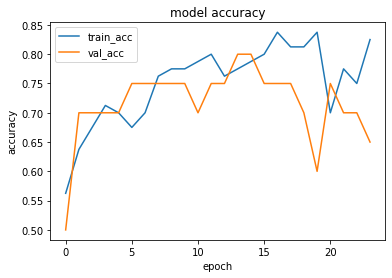

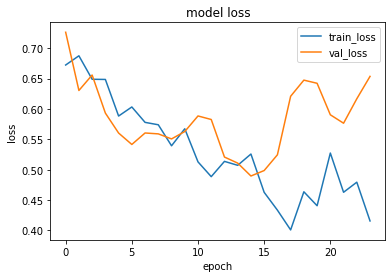

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.6896237]]


1it [00:00, 13025.79it/s]


prediction for video armflapping_3.mov is [[0.8464973]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_2.mov is [[0.7865969]]


1it [00:00, 11650.84it/s]


prediction for video control_1.mov is [[0.22934362]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.22317868]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.22352481]]
Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.7927 - accuracy: 0.3000 - precision: 0.1923 - recall: 0.1250 - val_loss: 0.6712 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6929 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - val_loss: 0.6562 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6624 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.9750 - val_loss: 0.6370 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6397 - accuracy: 0.6625 - precision: 0.6327 - recall: 0.7750 - val_loss: 0.6214 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5/75
3/3 [==============================] - 0s 131ms/

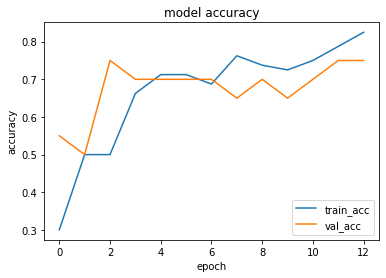

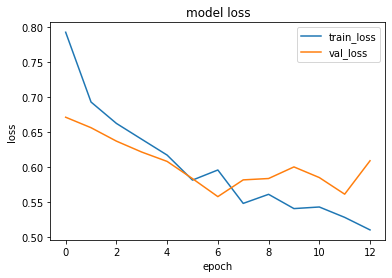

1it [00:00, 11915.64it/s]


prediction for video armflapping_1.mov is [[0.19530982]]


1it [00:00, 5152.71it/s]


prediction for video armflapping_3.mov is [[0.63186896]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.69883794]]


1it [00:00, 13934.56it/s]


prediction for video control_1.mov is [[0.15556827]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.14676318]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.14493117]]


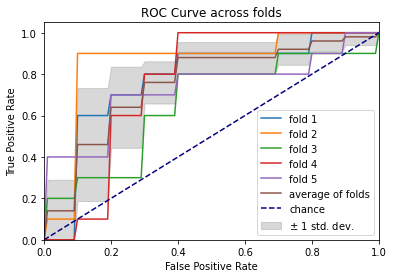

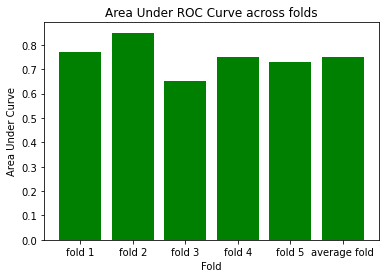

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6894 - accuracy: 0.4875 - precision: 0.4902 - recall: 0.6250 - val_loss: 0.6343 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6011 - accuracy: 0.7500 - precision: 0.7941 - recall: 0.6750 - val_loss: 0.6941 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6304 - accuracy: 0.6625 - precision: 0.6275 - recall: 0.8000 - val_loss: 0.5931 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5852 - accuracy: 0.7125 - precision: 0.7742 - recall: 0.6000 - val_loss: 0.6569 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5768 - accuracy: 0.7125 - precision: 0

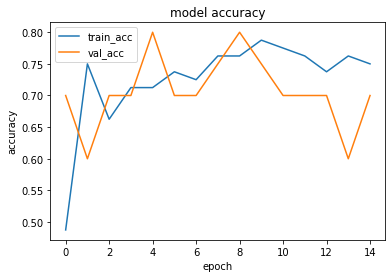

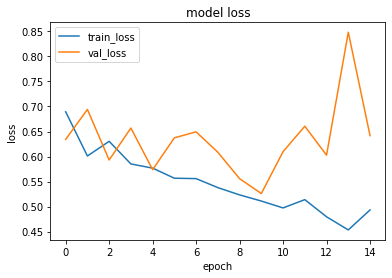

1it [00:00, 18808.54it/s]


prediction for video armflapping_1.mov is [[0.47894078]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.6117545]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.60976005]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.21988145]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.1745457]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.19536799]]
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.7234 - accuracy: 0.4750 - precision: 0.4762 - recall: 0.5000 - val_loss: 0.6669 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6414 - accuracy: 0.6000 - precision: 0.5714 - recall: 0.8000 - val_loss: 0.6709 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6251 - accuracy: 0.6500 - precision: 0.6111 - recall: 0.8250 - val_loss: 0.6538 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6195 - accuracy: 0.7000 - precision: 0.6818 - recall: 0.7500 - val_loss: 0.6263 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 146ms/

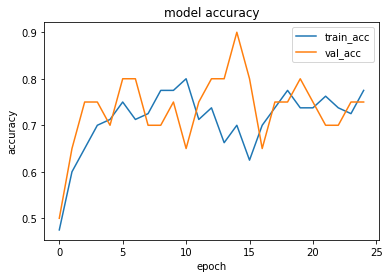

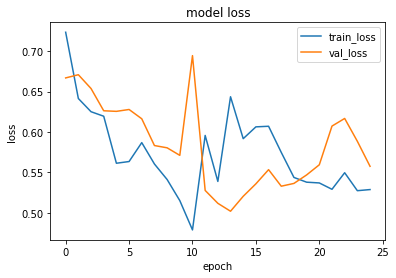

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.4743462]]


1it [00:00, 11781.75it/s]


prediction for video armflapping_3.mov is [[0.4119534]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.53210115]]


1it [00:00, 12671.61it/s]


prediction for video control_1.mov is [[0.32072657]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.25877136]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.24926105]]
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6812 - accuracy: 0.4750 - precision: 0.4643 - recall: 0.3250 - val_loss: 0.7125 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6098 - accuracy: 0.6125 - precision: 0.5652 - recall: 0.9750 - val_loss: 0.7094 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6008 - accuracy: 0.7500 - precision: 0.7174 - recall: 0.8250 - val_loss: 0.6932 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.5674 - accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.7080 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 163ms/

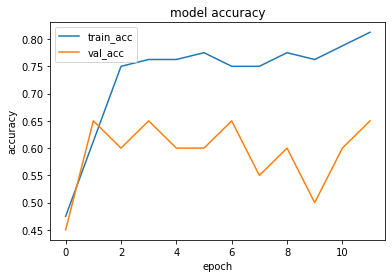

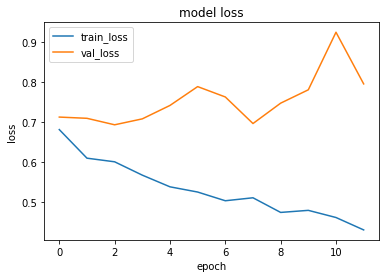

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.3292204]]


1it [00:00, 11008.67it/s]


prediction for video armflapping_3.mov is [[0.13755533]]


1it [00:00, 19691.57it/s]


prediction for video armflapping_2.mov is [[0.21250314]]


1it [00:00, 20460.02it/s]


prediction for video control_1.mov is [[0.28716612]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.285281]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.29518992]]
Epoch 1/75
3/3 [==============================] - 1s 193ms/step - loss: 0.7438 - accuracy: 0.3750 - precision: 0.4074 - recall: 0.5500 - val_loss: 0.6874 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6738 - accuracy: 0.6375 - precision: 0.6279 - recall: 0.6750 - val_loss: 0.6589 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6648 - accuracy: 0.6625 - precision: 0.8421 - recall: 0.4000 - val_loss: 0.6291 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6363 - accuracy: 0.7250 - precision: 0.6800 - recall: 0.8500 - val_loss: 0.6204 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 132ms/

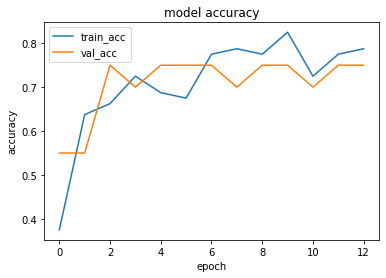

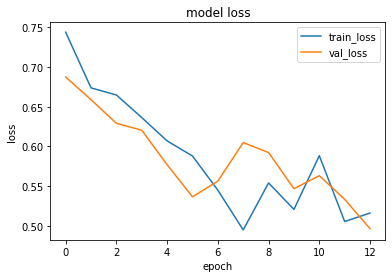

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.4101022]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.6504835]]


1it [00:00, 9892.23it/s]


prediction for video armflapping_2.mov is [[0.70156145]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.24259406]]


1it [00:00, 10754.63it/s]


prediction for video control_2.mov is [[0.19067103]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.19122821]]
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.7086 - accuracy: 0.4875 - precision: 0.4921 - recall: 0.7750 - val_loss: 0.6537 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6623 - accuracy: 0.6500 - precision: 0.6154 - recall: 0.8000 - val_loss: 0.5907 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 211ms/step - loss: 0.6201 - accuracy: 0.7250 - precision: 0.6875 - recall: 0.8250 - val_loss: 0.5618 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 168ms/step - loss: 0.5868 - accuracy: 0.7625 - precision: 0.8000 - recall: 0.7000 - val_loss: 0.5858 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 1s 180ms/

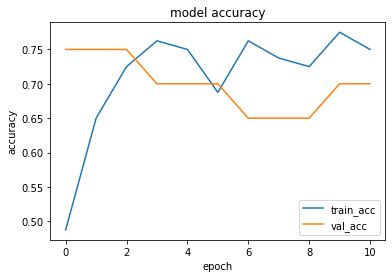

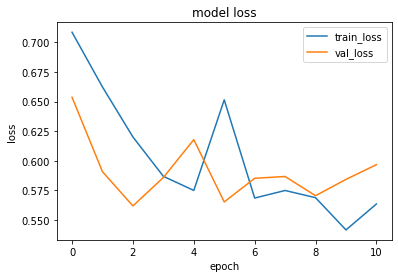

1it [00:00, 16320.25it/s]


prediction for video armflapping_1.mov is [[0.11396024]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.68705493]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.69902813]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.08528537]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.07737085]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.07688475]]


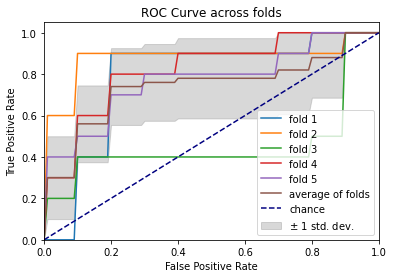

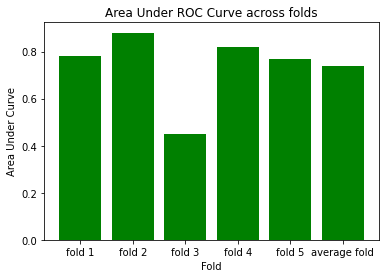

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6751 - accuracy: 0.5375 - precision: 0.5224 - recall: 0.8750 - val_loss: 0.6605 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6195 - accuracy: 0.7250 - precision: 0.8214 - recall: 0.5750 - val_loss: 0.5847 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6684 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.5469 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 153ms/step - loss: 0.5513 - accuracy: 0.7625 - precision: 0.7561 - recall: 0.7750 - val_loss: 0.6928 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5859 - accuracy: 0.7375 - precision: 0

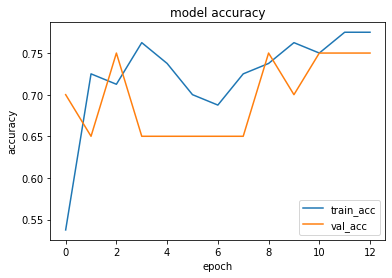

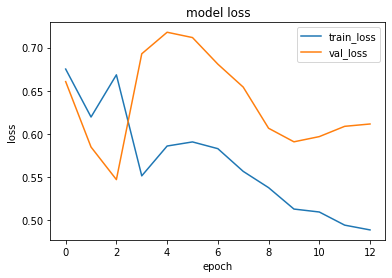

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.52701336]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_3.mov is [[0.5856854]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.65418327]]


1it [00:00, 8405.42it/s]


prediction for video control_1.mov is [[0.39869374]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.34960115]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.33106855]]
Epoch 1/75
3/3 [==============================] - 1s 180ms/step - loss: 0.6846 - accuracy: 0.5875 - precision: 0.5636 - recall: 0.7750 - val_loss: 0.6941 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6514 - accuracy: 0.5500 - precision: 0.5303 - recall: 0.8750 - val_loss: 0.5833 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6162 - accuracy: 0.6250 - precision: 0.5833 - recall: 0.8750 - val_loss: 0.6543 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.5888 - accuracy: 0.7125 - precision: 0.7073 - recall: 0.7250 - val_loss: 0.5928 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 145ms/

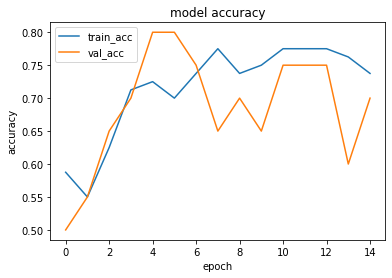

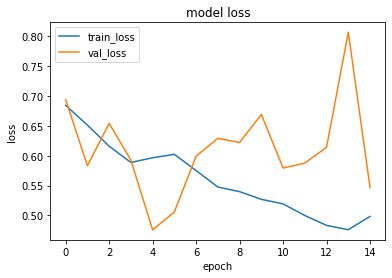

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.46363336]]


1it [00:00, 10979.85it/s]


prediction for video armflapping_3.mov is [[0.41907358]]


1it [00:00, 2421.65it/s]


prediction for video armflapping_2.mov is [[0.5938567]]


1it [00:00, 13888.42it/s]


prediction for video control_1.mov is [[0.34650698]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.2768141]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.2649351]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6885 - accuracy: 0.5250 - precision: 0.5312 - recall: 0.4250 - val_loss: 0.7000 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 159ms/step - loss: 0.5591 - accuracy: 0.7250 - precision: 0.6731 - recall: 0.8750 - val_loss: 0.8447 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.5815 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.8354 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 195ms/step - loss: 0.7022 - accuracy: 0.6500 - precision: 0.6500 - recall: 0.6500 - val_loss: 0.7051 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 153ms/s

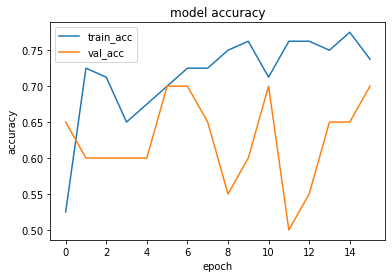

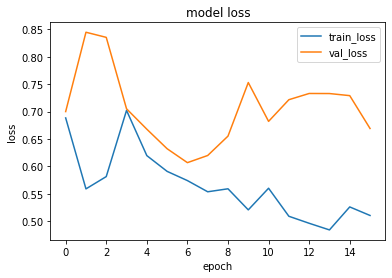

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.24870658]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.7317086]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.70533097]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.20443517]]


1it [00:00, 17772.47it/s]


prediction for video control_2.mov is [[0.19073448]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.19036797]]
Epoch 1/75
3/3 [==============================] - 1s 206ms/step - loss: 0.7205 - accuracy: 0.5625 - precision: 0.5926 - recall: 0.4000 - val_loss: 0.6481 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 196ms/step - loss: 0.6682 - accuracy: 0.6625 - precision: 0.6140 - recall: 0.8750 - val_loss: 0.6042 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6309 - accuracy: 0.6750 - precision: 0.6750 - recall: 0.6750 - val_loss: 0.5689 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.5720 - accuracy: 0.7500 - precision: 0.7632 - recall: 0.7250 - val_loss: 0.5795 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 131ms/

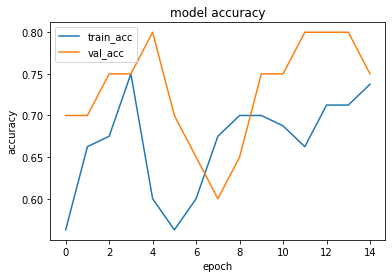

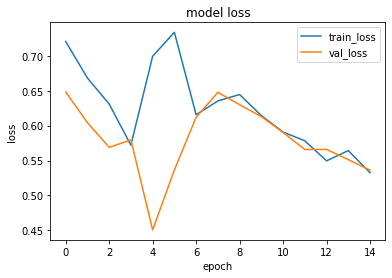

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.52267087]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.75429857]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.72689694]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.34284586]]


1it [00:00, 10645.44it/s]


prediction for video control_2.mov is [[0.2558579]]


1it [00:00, 13148.29it/s]


prediction for video control_3.mov is [[0.29793674]]
Epoch 1/75
3/3 [==============================] - 0s 173ms/step - loss: 0.7694 - accuracy: 0.5125 - precision: 0.5070 - recall: 0.9000 - val_loss: 0.6536 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 177ms/step - loss: 0.6774 - accuracy: 0.6000 - precision: 0.6429 - recall: 0.4500 - val_loss: 0.6563 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6609 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - val_loss: 0.6228 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6611 - accuracy: 0.6125 - precision: 0.5692 - recall: 0.9250 - val_loss: 0.6046 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 160ms/

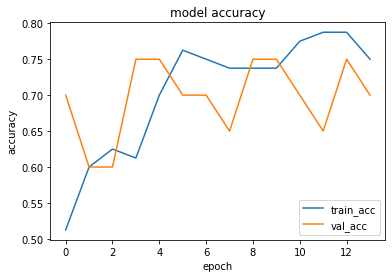

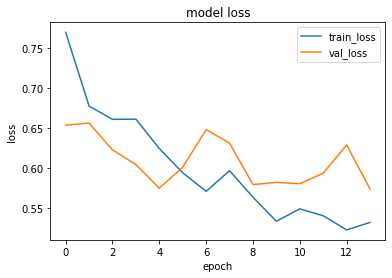

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.18658674]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.7621503]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.7691392]]


1it [00:00, 12520.31it/s]


prediction for video control_1.mov is [[0.15689954]]


1it [00:00, 18641.35it/s]


prediction for video control_2.mov is [[0.1460647]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.146191]]


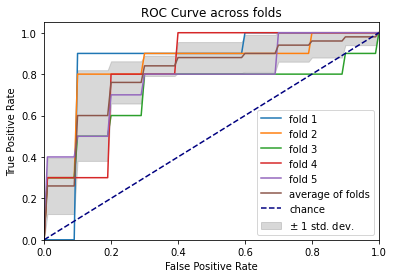

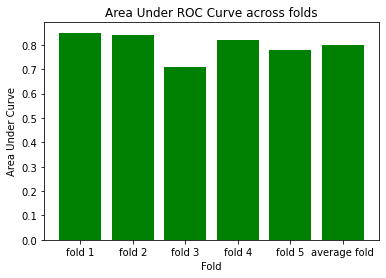

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.7679 - accuracy: 0.5125 - precision: 0.5077 - recall: 0.8250 - val_loss: 0.6894 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6657 - accuracy: 0.6625 - precision: 0.7241 - recall: 0.5250 - val_loss: 0.6732 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 186ms/step - loss: 0.6194 - accuracy: 0.7125 - precision: 0.7931 - recall: 0.5750 - val_loss: 0.6407 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 170ms/step - loss: 0.5657 - accuracy: 0.7250 - precision: 0.6957 - recall: 0.8000 - val_loss: 0.5706 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 1s 188ms/step - loss: 0.6103 - accuracy: 0.7125 - precision: 0

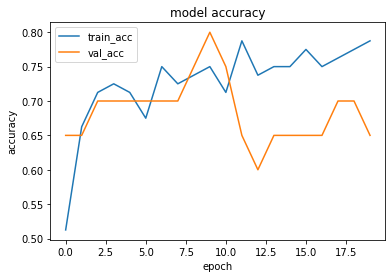

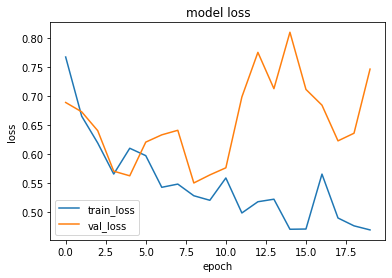

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.57729274]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.68398094]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.71490324]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.40401906]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.31047192]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.2854035]]
Epoch 1/75
3/3 [==============================] - 1s 182ms/step - loss: 0.6819 - accuracy: 0.5500 - precision: 0.5667 - recall: 0.4250 - val_loss: 0.5899 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 278ms/step - loss: 0.6452 - accuracy: 0.5875 - precision: 0.5493 - recall: 0.9750 - val_loss: 0.7131 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6807 - accuracy: 0.5750 - precision: 0.7143 - recall: 0.2500 - val_loss: 0.6402 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6265 - accuracy: 0.6875 - precision: 0.7586 - recall: 0.5500 - val_loss: 0.5317 - val_accuracy: 0.8500 - val_precision: 0.8182 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 157ms/s

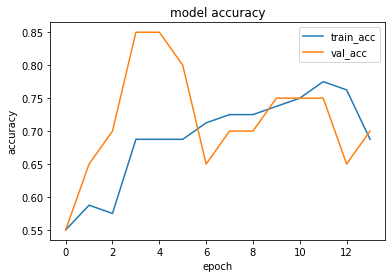

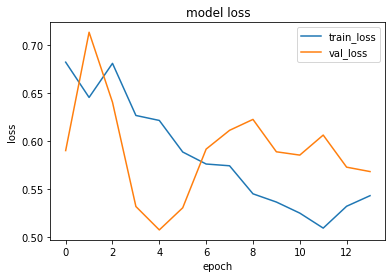

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.4724149]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.5154683]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.532196]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.43016857]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.4058341]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.40605816]]
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6688 - accuracy: 0.5500 - precision: 0.5526 - recall: 0.5250 - val_loss: 0.6849 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.5819 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.8000 - val_loss: 0.7668 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.5744 - accuracy: 0.7375 - precision: 0.7209 - recall: 0.7750 - val_loss: 0.6948 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.5521 - accuracy: 0.7625 - precision: 0.7838 - recall: 0.7250 - val_loss: 0.6525 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 152ms/

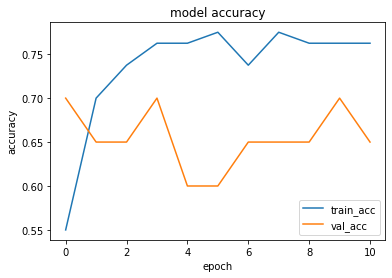

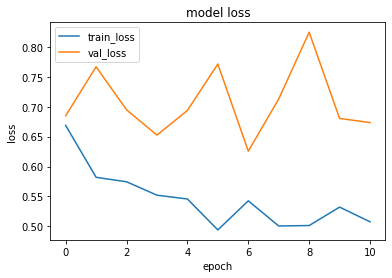

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.5045791]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5076538]]


1it [00:00, 14217.98it/s]


prediction for video armflapping_2.mov is [[0.6094235]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.3718388]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.28782123]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.27168274]]
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6778 - accuracy: 0.5875 - precision: 0.5745 - recall: 0.6750 - val_loss: 0.6532 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6466 - accuracy: 0.6250 - precision: 0.6786 - recall: 0.4750 - val_loss: 0.5930 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5879 - accuracy: 0.6750 - precision: 0.6842 - recall: 0.6500 - val_loss: 0.5526 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.5587 - accuracy: 0.7500 - precision: 0.7778 - recall: 0.7000 - val_loss: 0.5501 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0

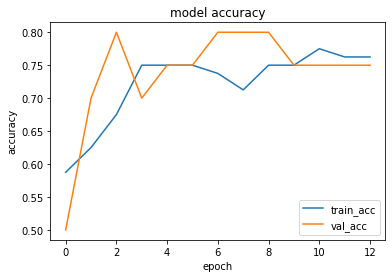

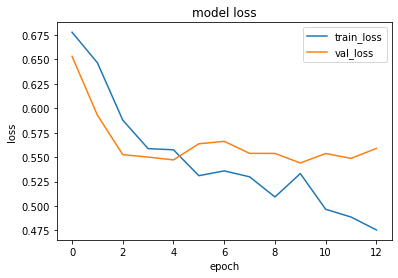

1it [00:00, 16912.52it/s]


prediction for video armflapping_1.mov is [[0.57696944]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.85792303]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.7809714]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.3030557]]


1it [00:00, 16448.25it/s]


prediction for video control_2.mov is [[0.26761836]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.26742646]]
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6836 - accuracy: 0.5375 - precision: 0.5263 - recall: 0.7500 - val_loss: 0.6257 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6409 - accuracy: 0.7375 - precision: 0.7317 - recall: 0.7500 - val_loss: 0.6334 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6518 - accuracy: 0.6500 - precision: 0.6000 - recall: 0.9000 - val_loss: 0.5777 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.5920 - accuracy: 0.7625 - precision: 0.8000 - recall: 0.7000 - val_loss: 0.5476 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 127ms/

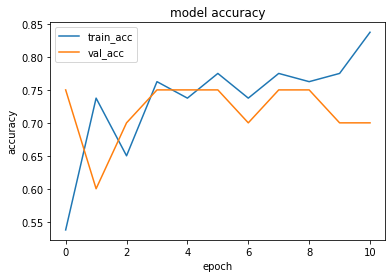

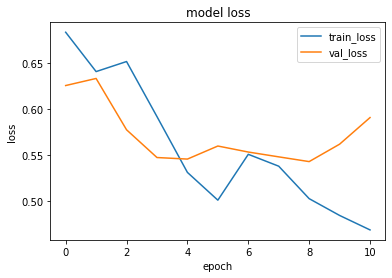

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.24788892]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.6102352]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.7215709]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.16291031]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.18548134]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.14307883]]


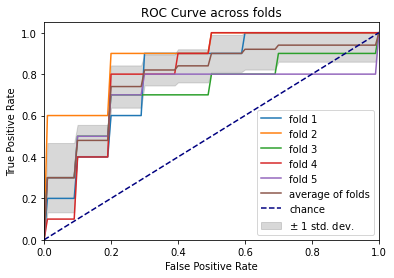

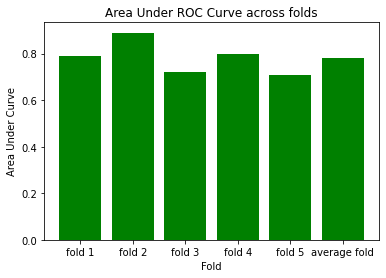

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6587 - accuracy: 0.5375 - precision: 0.5246 - recall: 0.8000 - val_loss: 0.9000 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6828 - accuracy: 0.6875 - precision: 0.6471 - recall: 0.8250 - val_loss: 0.6522 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6291 - accuracy: 0.6875 - precision: 0.8571 - recall: 0.4500 - val_loss: 0.6423 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.5671 - accuracy: 0.7250 - precision: 0.7647 - recall: 0.6500 - val_loss: 0.6996 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 130ms/step - loss: 0.5867 - accuracy: 0.7000 - precision: 0

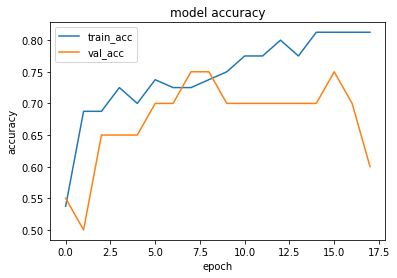

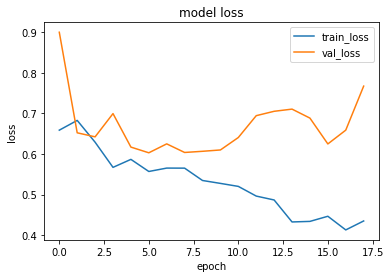

1it [00:00, 18236.10it/s]


prediction for video armflapping_1.mov is [[0.4925014]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5789453]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.61060625]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.3708732]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.3223132]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.2829033]]
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.7897 - accuracy: 0.5250 - precision: 0.5132 - recall: 0.9750 - val_loss: 0.6401 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6586 - accuracy: 0.6375 - precision: 0.7200 - recall: 0.4500 - val_loss: 0.6861 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6720 - accuracy: 0.5500 - precision: 0.7000 - recall: 0.1750 - val_loss: 0.6966 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 219ms/step - loss: 0.6359 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - val_loss: 0.6844 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 1s 204ms/s

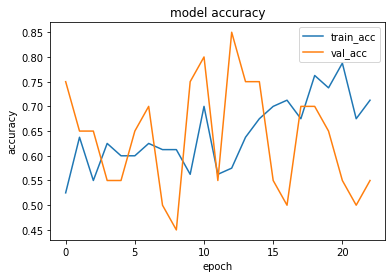

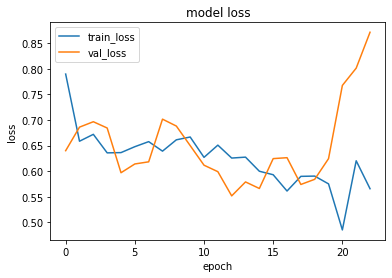

1it [00:00, 19239.93it/s]


prediction for video armflapping_1.mov is [[0.504194]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_3.mov is [[0.5505571]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.52337706]]


1it [00:00, 12633.45it/s]


prediction for video control_1.mov is [[0.4872543]]


1it [00:00, 16070.13it/s]


prediction for video control_2.mov is [[0.48047885]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.47925436]]
Epoch 1/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6938 - accuracy: 0.6250 - precision: 0.5862 - recall: 0.8500 - val_loss: 0.6822 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6286 - accuracy: 0.7000 - precision: 0.8077 - recall: 0.5250 - val_loss: 0.6730 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6052 - accuracy: 0.7250 - precision: 0.7143 - recall: 0.7500 - val_loss: 0.6752 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.5992 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.6616 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 1s 190ms/

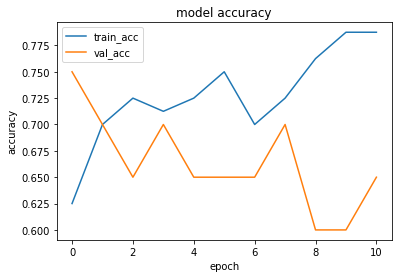

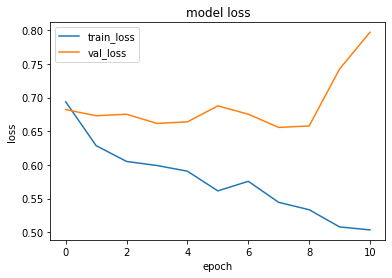

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.5679358]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.6847652]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.6873549]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.4717752]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.39007023]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.3941444]]
Epoch 1/75
3/3 [==============================] - 1s 198ms/step - loss: 0.8125 - accuracy: 0.4875 - precision: 0.4444 - recall: 0.1000 - val_loss: 0.6600 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6711 - accuracy: 0.5875 - precision: 0.5614 - recall: 0.8000 - val_loss: 0.6559 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6562 - accuracy: 0.6375 - precision: 0.5932 - recall: 0.8750 - val_loss: 0.6298 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6473 - accuracy: 0.6750 - precision: 0.6296 - recall: 0.8500 - val_loss: 0.5896 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 152ms/s

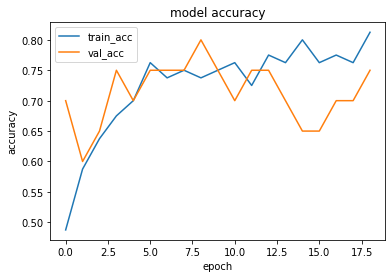

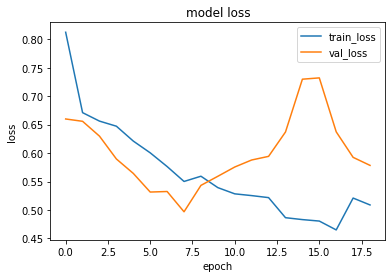

1it [00:00, 1677.72it/s]


prediction for video armflapping_1.mov is [[0.38392362]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.6530299]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.69016784]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.27235883]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.24189681]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.23825824]]
Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6829 - accuracy: 0.5750 - precision: 0.5577 - recall: 0.7250 - val_loss: 0.6506 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6502 - accuracy: 0.6000 - precision: 0.5690 - recall: 0.8250 - val_loss: 0.5969 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6226 - accuracy: 0.7500 - precision: 0.7778 - recall: 0.7000 - val_loss: 0.5682 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 177ms/step - loss: 0.5871 - accuracy: 0.7750 - precision: 0.7895 - recall: 0.7500 - val_loss: 0.5643 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5/75
3/3 [==============================] - 0s 143ms/

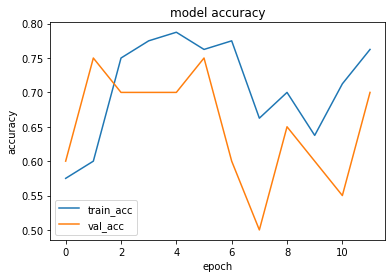

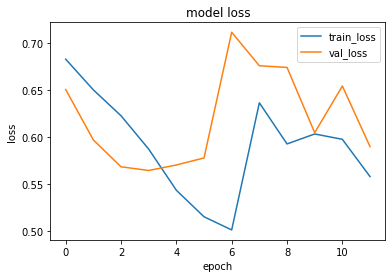

1it [00:00, 16710.37it/s]


prediction for video armflapping_1.mov is [[0.48970133]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.6875106]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.6011237]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.24782777]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.18084961]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.18166977]]


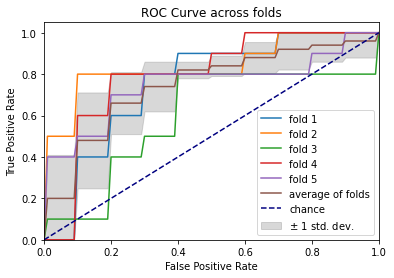

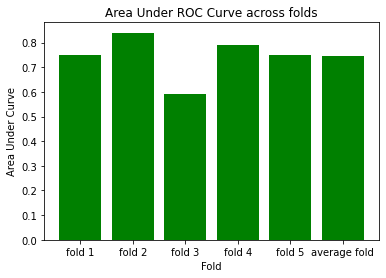

In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6863 - accuracy: 0.4625 - precision: 0.4746 - recall: 0.7000 - val_loss: 0.6491 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6758 - accuracy: 0.6625 - precision: 0.6327 - recall: 0.7750 - val_loss: 0.6868 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6080 - accuracy: 0.6750 - precision: 0.7188 - recall: 0.5750 - val_loss: 0.6345 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.5789 - accuracy: 0.7500 - precision: 0.7941 - recall: 0.6750 - val_loss: 0.5779 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 146ms/step - loss: 0.5756 - accuracy: 0.7125 - precision: 0

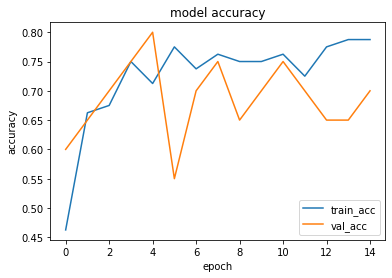

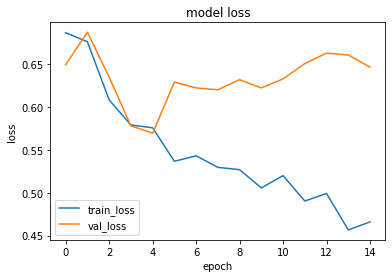

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.40210736]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5169191]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.59892905]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.28376853]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.26137328]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.2289862]]
Epoch 1/75
3/3 [==============================] - 1s 244ms/step - loss: 0.7021 - accuracy: 0.5250 - precision: 0.5238 - recall: 0.5500 - val_loss: 0.6991 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6596 - accuracy: 0.6250 - precision: 0.6786 - recall: 0.4750 - val_loss: 0.6092 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 197ms/step - loss: 0.6721 - accuracy: 0.5375 - precision: 0.5200 - recall: 0.9750 - val_loss: 0.6039 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6234 - accuracy: 0.7250 - precision: 0.6875 - recall: 0.8250 - val_loss: 0.6253 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 166ms/s

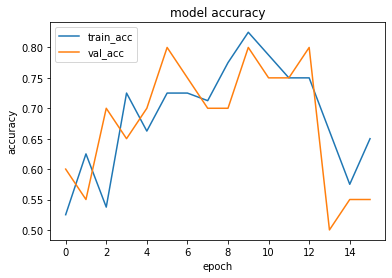

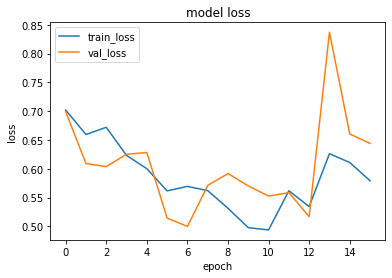

1it [00:00, 16644.06it/s]


prediction for video armflapping_1.mov is [[0.56745946]]


1it [00:00, 8192.00it/s]


prediction for video armflapping_3.mov is [[0.64245516]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.60090566]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.5466149]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.5382612]]


1it [00:00, 12826.62it/s]


prediction for video control_3.mov is [[0.53677654]]
Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.7690 - accuracy: 0.5500 - precision: 0.5303 - recall: 0.8750 - val_loss: 0.6849 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6710 - accuracy: 0.6625 - precision: 0.6857 - recall: 0.6000 - val_loss: 0.6934 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6423 - accuracy: 0.6375 - precision: 0.6078 - recall: 0.7750 - val_loss: 0.6953 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6053 - accuracy: 0.6250 - precision: 0.5735 - recall: 0.9750 - val_loss: 0.7161 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 178ms/

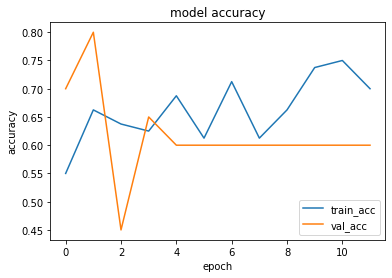

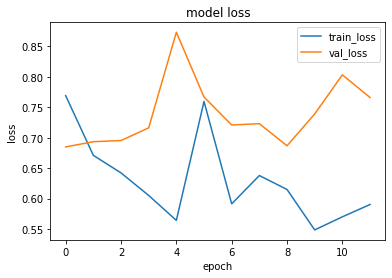

1it [00:00, 18558.87it/s]


prediction for video armflapping_1.mov is [[0.31771576]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.65334517]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.33858228]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.30572426]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.3006335]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.29942033]]
Epoch 1/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6933 - accuracy: 0.4875 - precision: 0.4925 - recall: 0.8250 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 168ms/step - loss: 0.7016 - accuracy: 0.5625 - precision: 0.6190 - recall: 0.3250 - val_loss: 0.6460 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 179ms/step - loss: 0.6462 - accuracy: 0.7000 - precision: 0.6739 - recall: 0.7750 - val_loss: 0.6149 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6169 - accuracy: 0.7250 - precision: 0.7045 - recall: 0.7750 - val_loss: 0.5733 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0

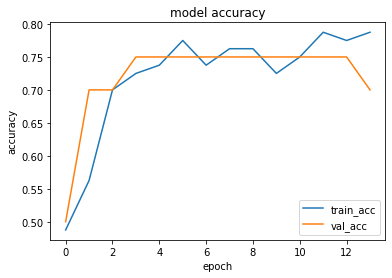

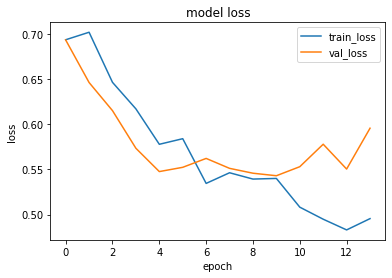

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.5608664]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.7331117]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.78539133]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.22217631]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.20027831]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.19903913]]
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6884 - accuracy: 0.5375 - precision: 0.5333 - recall: 0.6000 - val_loss: 0.6224 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6323 - accuracy: 0.6750 - precision: 0.6522 - recall: 0.7500 - val_loss: 0.5627 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 192ms/step - loss: 0.5721 - accuracy: 0.7250 - precision: 0.7250 - recall: 0.7250 - val_loss: 0.5995 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.5493 - accuracy: 0.7250 - precision: 0.7045 - recall: 0.7750 - val_loss: 0.5517 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 155ms/

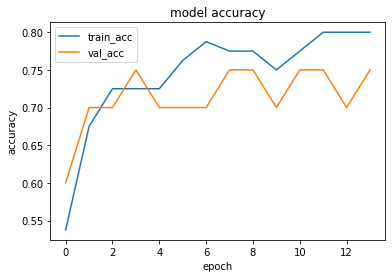

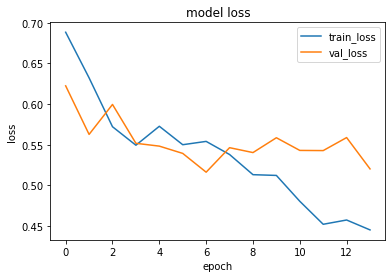

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.75691193]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.9050587]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.8687792]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.20786074]]


1it [00:00, 11244.78it/s]


prediction for video control_2.mov is [[0.1902465]]


1it [00:00, 17772.47it/s]


prediction for video control_3.mov is [[0.19703728]]


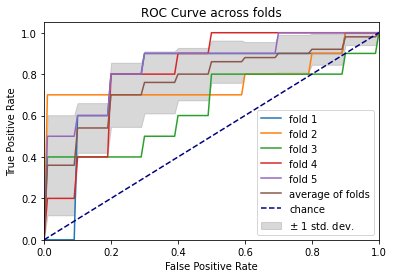

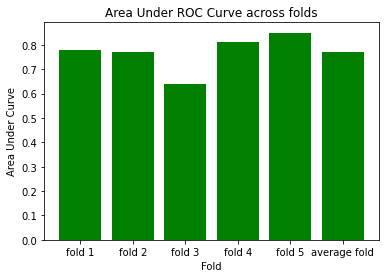

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 165ms/step - loss: 0.7278 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3000 - val_loss: 0.7065 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6478 - accuracy: 0.7250 - precision: 0.6800 - recall: 0.8500 - val_loss: 0.6687 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6279 - accuracy: 0.6625 - precision: 0.6102 - recall: 0.9000 - val_loss: 0.6613 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 154ms/step - loss: 0.5927 - accuracy: 0.6875 - precision: 0.7419 - recall: 0.5750 - val_loss: 0.6577 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 156ms/step - loss: 0.5883 - accuracy: 0.6625 - precision: 0

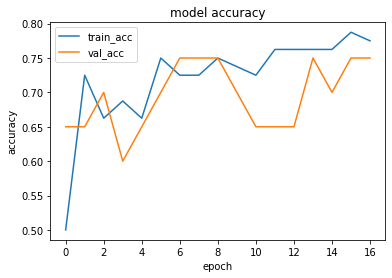

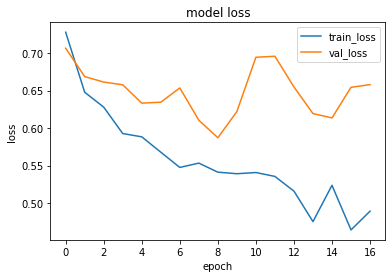

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.54088324]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.6673091]]


1it [00:00, 11748.75it/s]


prediction for video armflapping_2.mov is [[0.6762788]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.42130202]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.36822265]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.33580238]]
Epoch 1/75
3/3 [==============================] - 0s 172ms/step - loss: 0.6838 - accuracy: 0.5250 - precision: 0.5294 - recall: 0.4500 - val_loss: 0.6233 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 186ms/step - loss: 0.6994 - accuracy: 0.6500 - precision: 0.6034 - recall: 0.8750 - val_loss: 0.6350 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6350 - accuracy: 0.7000 - precision: 0.7353 - recall: 0.6250 - val_loss: 0.5988 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 184ms/step - loss: 0.6239 - accuracy: 0.6875 - precision: 0.6415 - recall: 0.8500 - val_loss: 0.5808 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 155ms/

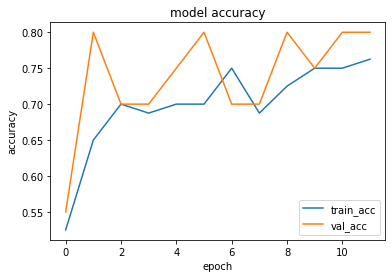

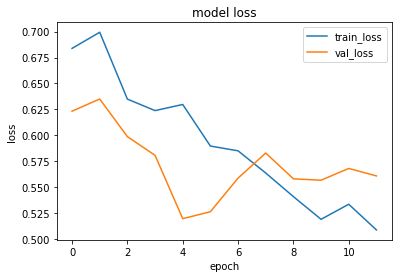

1it [00:00, 17331.83it/s]


prediction for video armflapping_1.mov is [[0.50103647]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.5106616]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.53592753]]


1it [00:00, 16448.25it/s]


prediction for video control_1.mov is [[0.47393855]]


1it [00:00, 11491.24it/s]


prediction for video control_2.mov is [[0.46402162]]


1it [00:00, 19599.55it/s]


prediction for video control_3.mov is [[0.45776433]]
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6827 - accuracy: 0.6000 - precision: 0.5606 - recall: 0.9250 - val_loss: 0.7256 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6733 - accuracy: 0.6250 - precision: 0.6562 - recall: 0.5250 - val_loss: 0.6814 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6067 - accuracy: 0.7375 - precision: 0.6939 - recall: 0.8500 - val_loss: 0.6773 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.5331 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.7699 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 181ms/

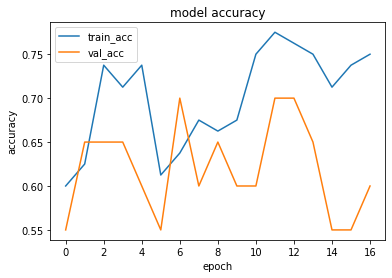

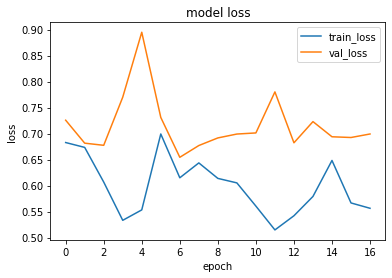

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.45990908]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.44817638]]


1it [00:00, 15477.14it/s]


prediction for video armflapping_2.mov is [[0.5147605]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.4095647]]


1it [00:00, 8388.61it/s]


prediction for video control_2.mov is [[0.39588478]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.39636222]]
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.7517 - accuracy: 0.4875 - precision: 0.4921 - recall: 0.7750 - val_loss: 0.6786 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6722 - accuracy: 0.6625 - precision: 0.7407 - recall: 0.5000 - val_loss: 0.6529 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 159ms/step - loss: 0.6541 - accuracy: 0.6250 - precision: 0.6562 - recall: 0.5250 - val_loss: 0.6124 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6174 - accuracy: 0.7000 - precision: 0.6739 - recall: 0.7750 - val_loss: 0.5573 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 153ms/

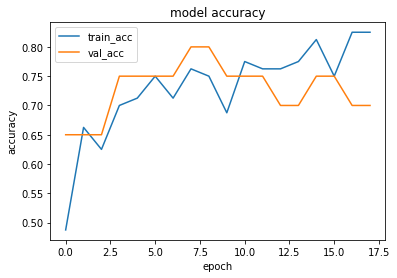

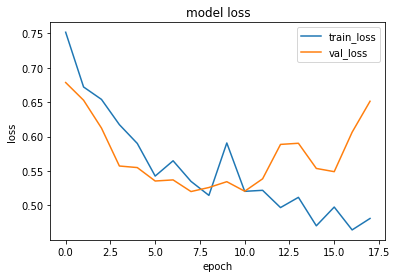

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.601483]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.6572114]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.49664813]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.25359446]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.19281864]]


In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6699 - accuracy: 0.6375 - precision_169: 0.6222 - recall_169: 0.7000 - val_loss: 0.6269 - val_accuracy: 0.6000 - val_precision_169: 0.5556 - val_recall_169: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6047 - accuracy: 0.6250 - precision_169: 0.5862 - recall_169: 0.8500 - val_loss: 0.7005 - val_accuracy: 0.6500 - val_precision_169: 0.6154 - val_recall_169: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5937 - accuracy: 0.7250 - precision_169: 0.7368 - recall_169: 0.7000 - val_loss: 0.6673 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.5704 - accuracy: 0.7125 - precision_169: 0.7179 - recall_169: 0.7000 - val_loss: 0.6066 - val_accuracy: 0.7500 - val_precision_169: 0.6923 - val_recall_169: 0.9000
Epoch 5/75
3/3 [==============================] 

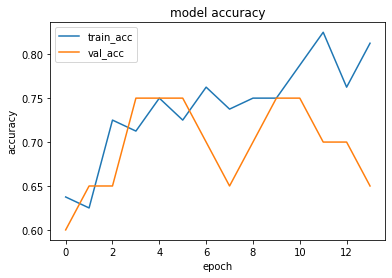

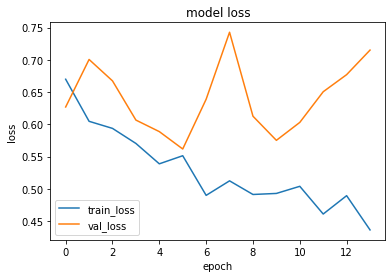

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.49159864]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.6216289]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_2.mov is [[0.64285153]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.39012486]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.35380825]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.34214312]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7236 - accuracy: 0.4750 - precision_170: 0.4583 - recall_170: 0.2750 - val_loss: 0.6403 - val_accuracy: 0.5500 - val_precision_170: 0.5263 - val_recall_170: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6851 - accuracy: 0.5250 - precision_170: 0.5128 - recall_170: 1.0000 - val_loss: 0.6127 - val_accuracy: 0.7000 - val_precision_170: 0.6429 - val_recall_170: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6751 - accuracy: 0.6500 - precision_170: 0.6200 - recall_170: 0.7750 - val_loss: 0.6156 - val_accuracy: 0.8500 - val_precision_170: 0.8889 - val_recall_170: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6386 - accuracy: 0.7000 - precision_170: 0.7105 - recall_170: 0.6750 - val_loss: 0.5722 - val_accuracy: 0.8500 - val_precision_170: 0.8182 - val_recall_170: 0.

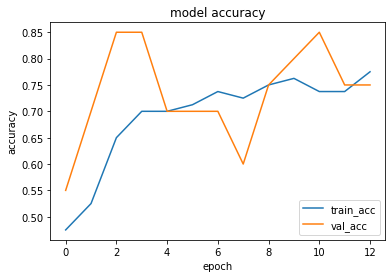

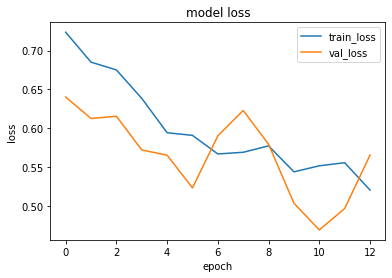

1it [00:00, 9177.91it/s]


prediction for video armflapping_1.mov is [[0.48036402]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.44624808]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.5021429]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.44937938]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.43126675]]


1it [00:00, 16131.94it/s]


prediction for video control_3.mov is [[0.42333308]]
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6802 - accuracy: 0.4750 - precision_171: 0.4815 - recall_171: 0.6500 - val_loss: 0.8684 - val_accuracy: 0.5000 - val_precision_171: 0.0000e+00 - val_recall_171: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7107 - accuracy: 0.6000 - precision_171: 0.6429 - recall_171: 0.4500 - val_loss: 0.7071 - val_accuracy: 0.4500 - val_precision_171: 0.4737 - val_recall_171: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6288 - accuracy: 0.5625 - precision_171: 0.5342 - recall_171: 0.9750 - val_loss: 0.7142 - val_accuracy: 0.4500 - val_precision_171: 0.4737 - val_recall_171: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6242 - accuracy: 0.6250 - precision_171: 0.5833 - recall_171: 0.8750 - val_loss: 0.7058 - val_accuracy: 0.7000 - val_precision_171: 0.7000 - val_recall

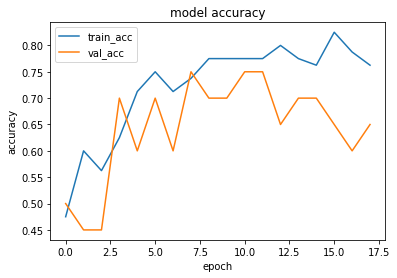

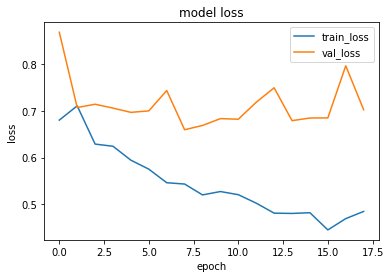

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.32757968]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.30439204]]


1it [00:00, 13662.23it/s]


prediction for video armflapping_2.mov is [[0.50695384]]


1it [00:00, 12018.06it/s]


prediction for video control_1.mov is [[0.2697076]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.2495856]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.24653584]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7144 - accuracy: 0.5000 - precision_172: 0.5000 - recall_172: 0.2750 - val_loss: 0.6655 - val_accuracy: 0.5500 - val_precision_172: 0.5263 - val_recall_172: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6657 - accuracy: 0.6000 - precision_172: 0.5556 - recall_172: 1.0000 - val_loss: 0.6129 - val_accuracy: 0.7500 - val_precision_172: 0.7273 - val_recall_172: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6291 - accuracy: 0.7000 - precision_172: 0.6739 - recall_172: 0.7750 - val_loss: 0.5727 - val_accuracy: 0.7500 - val_precision_172: 0.6923 - val_recall_172: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6028 - accuracy: 0.6625 - precision_172: 0.6512 - recall_172: 0.7000 - val_loss: 0.5600 - val_accuracy: 0.8000 - val_precision_172: 0.8000 - val_recall_172: 0.

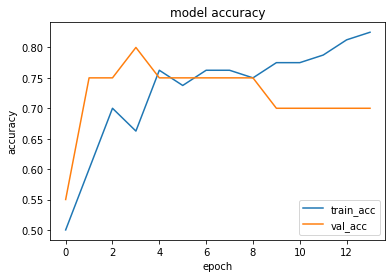

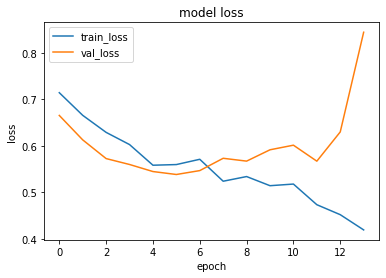

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.74335444]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.7749541]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.7836789]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.20634061]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.14814073]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.14682204]]
Epoch 1/75
3/3 [==============================] - 1s 196ms/step - loss: 0.7353 - accuracy: 0.5000 - precision_173: 0.5000 - recall_173: 0.1750 - val_loss: 0.6578 - val_accuracy: 0.5500 - val_precision_173: 0.5263 - val_recall_173: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6756 - accuracy: 0.5125 - precision_173: 0.5063 - recall_173: 1.0000 - val_loss: 0.6344 - val_accuracy: 0.8000 - val_precision_173: 0.8000 - val_recall_173: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6434 - accuracy: 0.6875 - precision_173: 0.6531 - recall_173: 0.8000 - val_loss: 0.6044 - val_accuracy: 0.7000 - val_precision_173: 0.7500 - val_recall_173: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6084 - accuracy: 0.7250 - precision_173: 0.6875 - recall_173: 0.8250 - val_loss: 0.6945 - val_accuracy: 0.6000 - val_precision_173: 0.5556 - val_recall_173: 1.

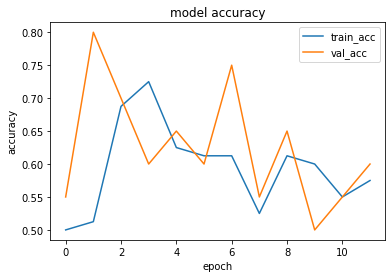

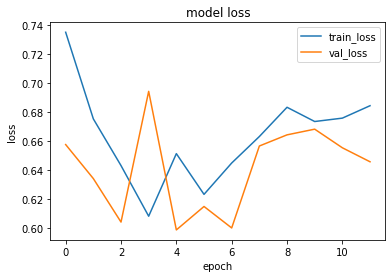

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.41445202]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.48841906]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.4776261]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.39802617]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.3948412]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.39404267]]


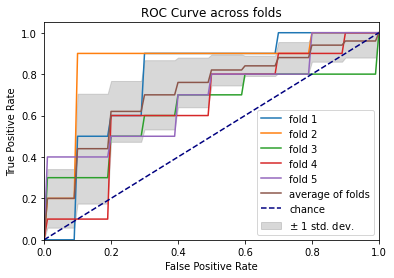

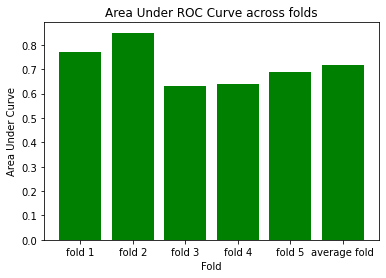

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6877 - accuracy: 0.5125 - precision_175: 0.5091 - recall_175: 0.7000 - val_loss: 0.7769 - val_accuracy: 0.5000 - val_precision_175: 0.5000 - val_recall_175: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6284 - accuracy: 0.6625 - precision_175: 0.6226 - recall_175: 0.8250 - val_loss: 0.6492 - val_accuracy: 0.6000 - val_precision_175: 0.6667 - val_recall_175: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6041 - accuracy: 0.7000 - precision_175: 0.7667 - recall_175: 0.5750 - val_loss: 0.6565 - val_accuracy: 0.6500 - val_precision_175: 0.6000 - val_recall_175: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.5965 - accuracy: 0.7375 - precision_175: 0.7111 - recall_175: 0.8000 - val_loss: 0.6906 - val_accuracy: 0.7000 - val_precision_175: 0.6429 - val_recall_175: 0.9000
Epoch 5/75
3/3 [==============================] 

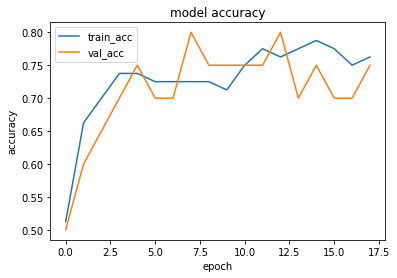

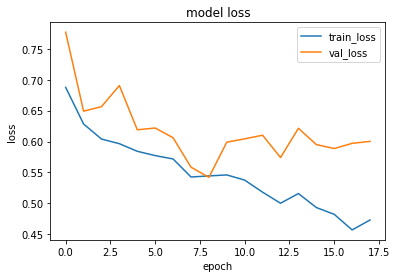

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.4304359]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.5502516]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.61393046]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.2452125]]


1it [00:00, 18315.74it/s]


prediction for video control_2.mov is [[0.2211788]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.20850116]]
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6798 - accuracy: 0.6250 - precision_176: 0.5833 - recall_176: 0.8750 - val_loss: 0.8879 - val_accuracy: 0.5000 - val_precision_176: 0.0000e+00 - val_recall_176: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.7144 - accuracy: 0.4875 - precision_176: 0.3333 - recall_176: 0.0250 - val_loss: 0.6485 - val_accuracy: 0.7000 - val_precision_176: 0.7500 - val_recall_176: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6520 - accuracy: 0.6375 - precision_176: 0.6222 - recall_176: 0.7000 - val_loss: 0.5989 - val_accuracy: 0.7000 - val_precision_176: 0.6429 - val_recall_176: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6624 - accuracy: 0.6375 - precision_176: 0.5932 - recall_176: 0.8750 - val_loss: 0.5796 - val_accuracy: 0.8500 - val_precision_176: 0.8182 - val_recall

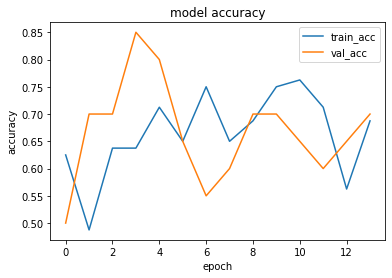

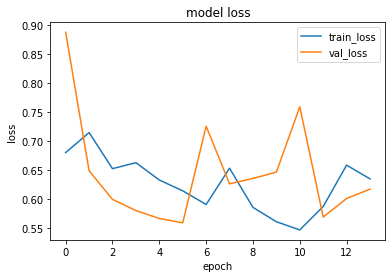

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.5036381]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.5520792]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5480587]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.48514828]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.47559643]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.47472]]
Epoch 1/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6510 - accuracy: 0.5250 - precision_177: 0.5238 - recall_177: 0.5500 - val_loss: 0.7968 - val_accuracy: 0.5500 - val_precision_177: 0.5333 - val_recall_177: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.8358 - accuracy: 0.6375 - precision_177: 0.5902 - recall_177: 0.9000 - val_loss: 0.6789 - val_accuracy: 0.6500 - val_precision_177: 0.6667 - val_recall_177: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6614 - accuracy: 0.6000 - precision_177: 0.6053 - recall_177: 0.5750 - val_loss: 0.6867 - val_accuracy: 0.6500 - val_precision_177: 1.0000 - val_recall_177: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6288 - accuracy: 0.6375 - precision_177: 0.7895 - recall_177: 0.3750 - val_loss: 0.6608 - val_accuracy: 0.5500 - val_precision_177: 0.5714 - val_recall_177: 0.400

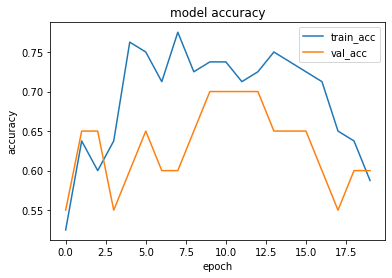

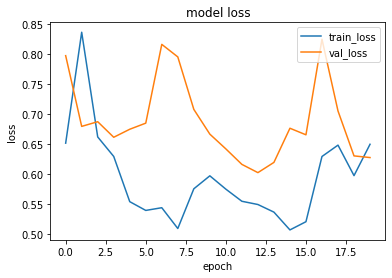

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.45705888]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.40354747]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.4540307]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.45283556]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.4510133]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.45073617]]
Epoch 1/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6781 - accuracy: 0.5375 - precision_178: 0.5254 - recall_178: 0.7750 - val_loss: 0.5883 - val_accuracy: 0.7000 - val_precision_178: 0.6429 - val_recall_178: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6266 - accuracy: 0.7250 - precision_178: 0.7143 - recall_178: 0.7500 - val_loss: 0.5411 - val_accuracy: 0.7500 - val_precision_178: 0.6923 - val_recall_178: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6916 - accuracy: 0.6500 - precision_178: 0.6111 - recall_178: 0.8250 - val_loss: 0.5558 - val_accuracy: 0.7500 - val_precision_178: 0.7273 - val_recall_178: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 208ms/step - loss: 0.6054 - accuracy: 0.7500 - precision_178: 0.7778 - recall_178: 0.7000 - val_loss: 0.5580 - val_accuracy: 0.7500 - val_precision_178: 0.7273 - val_recall_178: 0.

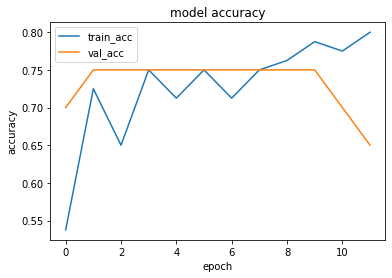

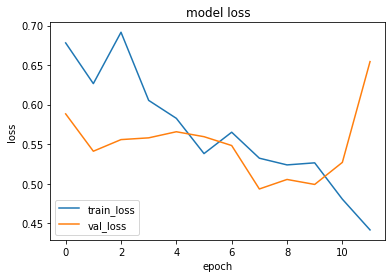

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.3980477]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.6342753]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.7297976]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.3483838]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.26000404]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.28018823]]
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6746 - accuracy: 0.6375 - precision_179: 0.6341 - recall_179: 0.6500 - val_loss: 0.5723 - val_accuracy: 0.7500 - val_precision_179: 0.7273 - val_recall_179: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6804 - accuracy: 0.6375 - precision_179: 0.5902 - recall_179: 0.9000 - val_loss: 0.5947 - val_accuracy: 0.7000 - val_precision_179: 0.8333 - val_recall_179: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6159 - accuracy: 0.7000 - precision_179: 0.7857 - recall_179: 0.5500 - val_loss: 0.6143 - val_accuracy: 0.6000 - val_precision_179: 0.7500 - val_recall_179: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.5884 - accuracy: 0.7000 - precision_179: 0.7667 - recall_179: 0.5750 - val_loss: 0.5780 - val_accuracy: 0.6500 - val_precision_179: 0.7143 - val_recall_179: 0.

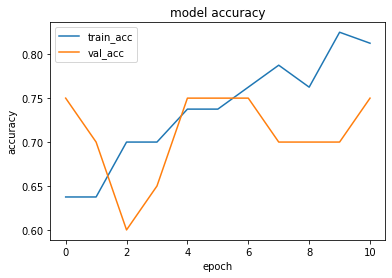

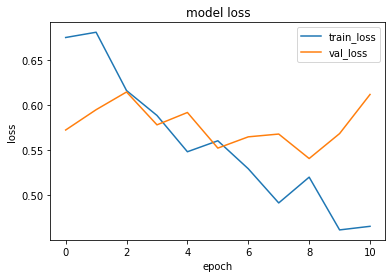

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.5667913]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.7611847]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.80348575]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.23717451]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.22739571]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.19310144]]


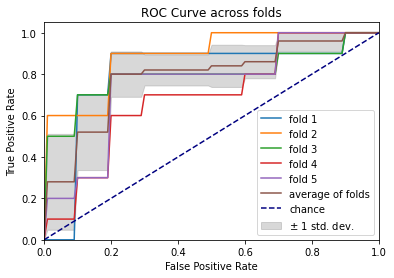

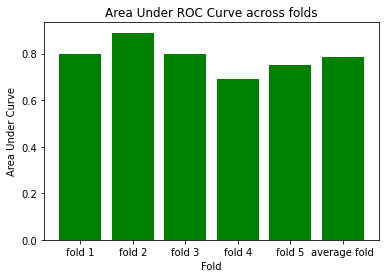

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6611 - accuracy: 0.5875 - precision_181: 0.5854 - recall_181: 0.6000 - val_loss: 0.7174 - val_accuracy: 0.6500 - val_precision_181: 0.6000 - val_recall_181: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6318 - accuracy: 0.7250 - precision_181: 0.6957 - recall_181: 0.8000 - val_loss: 0.6942 - val_accuracy: 0.6000 - val_precision_181: 0.7500 - val_recall_181: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6218 - accuracy: 0.6750 - precision_181: 0.8182 - recall_181: 0.4500 - val_loss: 0.7000 - val_accuracy: 0.6500 - val_precision_181: 0.6364 - val_recall_181: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.5950 - accuracy: 0.7250 - precision_181: 0.7250 - recall_181: 0.7250 - val_loss: 0.6842 - val_accuracy: 0.7000 - val_precision_181: 0.6429 - val_recall_181: 0.9000
Epoch 5/75
3/3 [==============================] 

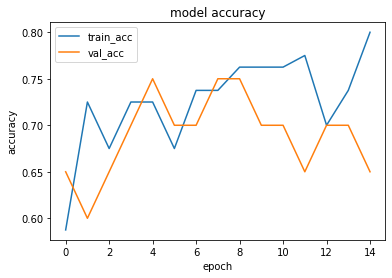

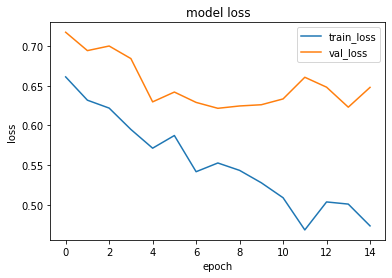

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.34196138]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_3.mov is [[0.5665014]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.59809005]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.16774595]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.15117696]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.15777001]]
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.7260 - accuracy: 0.5500 - precision_182: 0.5476 - recall_182: 0.5750 - val_loss: 0.6372 - val_accuracy: 0.6500 - val_precision_182: 0.6000 - val_recall_182: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6614 - accuracy: 0.6625 - precision_182: 0.6327 - recall_182: 0.7750 - val_loss: 0.6204 - val_accuracy: 0.8000 - val_precision_182: 0.8000 - val_recall_182: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6477 - accuracy: 0.6750 - precision_182: 0.6842 - recall_182: 0.6500 - val_loss: 0.5794 - val_accuracy: 0.8000 - val_precision_182: 0.8000 - val_recall_182: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6189 - accuracy: 0.6875 - precision_182: 0.6596 - recall_182: 0.7750 - val_loss: 0.5306 - val_accuracy: 0.7500 - val_precision_182: 0.7273 - val_recall_182: 0.

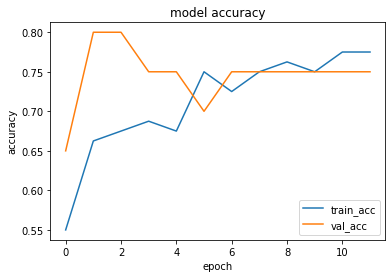

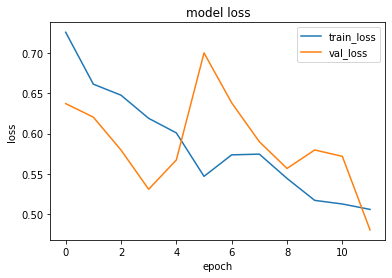

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.49893397]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.4481915]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.50827396]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.47915626]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.4661361]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.46495116]]
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6853 - accuracy: 0.4750 - precision_183: 0.4800 - recall_183: 0.6000 - val_loss: 0.6886 - val_accuracy: 0.5500 - val_precision_183: 0.5294 - val_recall_183: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6093 - accuracy: 0.5875 - precision_183: 0.5522 - recall_183: 0.9250 - val_loss: 0.7125 - val_accuracy: 0.6500 - val_precision_183: 0.6154 - val_recall_183: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.5975 - accuracy: 0.7250 - precision_183: 0.7143 - recall_183: 0.7500 - val_loss: 0.6918 - val_accuracy: 0.6000 - val_precision_183: 0.6667 - val_recall_183: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 128ms/step - loss: 0.5648 - accuracy: 0.7375 - precision_183: 0.7714 - recall_183: 0.6750 - val_loss: 0.6462 - val_accuracy: 0.6500 - val_precision_183: 0.6364 - val_recall_183: 0.

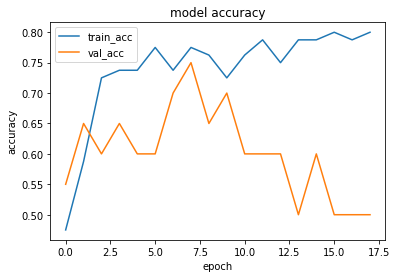

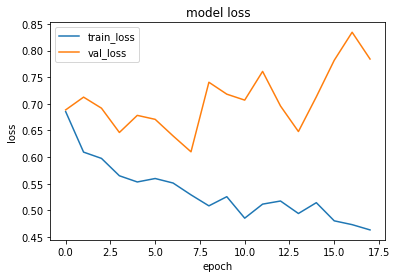

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.29372948]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_3.mov is [[0.1910108]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.6649468]]


1it [00:00, 13148.29it/s]


prediction for video control_1.mov is [[0.26949933]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.2569484]]


1it [00:00, 11915.64it/s]


prediction for video control_3.mov is [[0.25881547]]
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7328 - accuracy: 0.5500 - precision_184: 0.5556 - recall_184: 0.5000 - val_loss: 0.6543 - val_accuracy: 0.6000 - val_precision_184: 0.5556 - val_recall_184: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6756 - accuracy: 0.5500 - precision_184: 0.5286 - recall_184: 0.9250 - val_loss: 0.6410 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6494 - accuracy: 0.7250 - precision_184: 0.6875 - recall_184: 0.8250 - val_loss: 0.6074 - val_accuracy: 0.6500 - val_precision_184: 0.6154 - val_recall_184: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6290 - accuracy: 0.7000 - precision_184: 0.6600 - recall_184: 0.8250 - val_loss: 0.5704 - val_accuracy: 0.7000 - val_precision_184: 0.7000 - val_recall_184: 0.

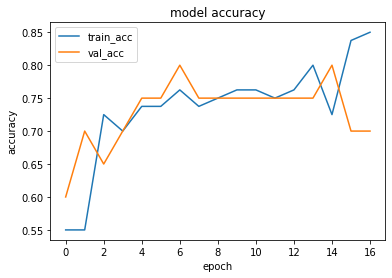

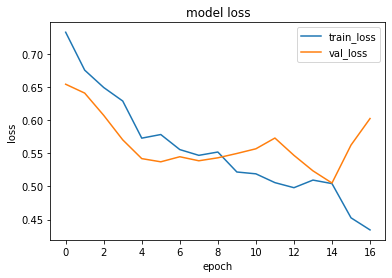

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.4016436]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.54524344]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.73861027]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.3278293]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.21312526]]


1it [00:00, 11915.64it/s]


prediction for video control_3.mov is [[0.26708078]]
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7364 - accuracy: 0.4625 - precision_185: 0.4286 - recall_185: 0.2250 - val_loss: 0.6488 - val_accuracy: 0.5500 - val_precision_185: 0.5263 - val_recall_185: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6808 - accuracy: 0.5375 - precision_185: 0.5195 - recall_185: 1.0000 - val_loss: 0.6279 - val_accuracy: 0.7500 - val_precision_185: 0.7273 - val_recall_185: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6388 - accuracy: 0.7000 - precision_185: 0.6600 - recall_185: 0.8250 - val_loss: 0.6303 - val_accuracy: 0.6500 - val_precision_185: 0.7143 - val_recall_185: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6505 - accuracy: 0.6500 - precision_185: 0.6579 - recall_185: 0.6250 - val_loss: 0.6022 - val_accuracy: 0.6500 - val_precision_185: 0.7143 - val_recall_185: 0.

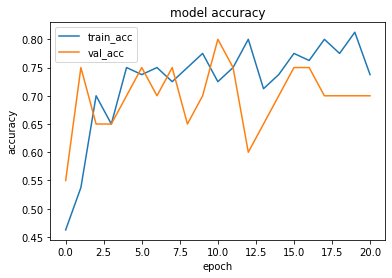

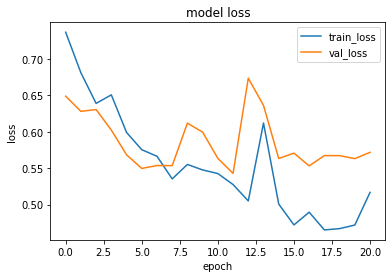

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.5910981]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_3.mov is [[0.75671947]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.71206707]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.20328477]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.16000953]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.17492971]]


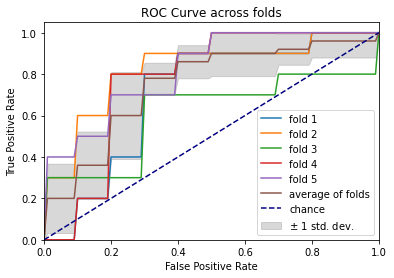

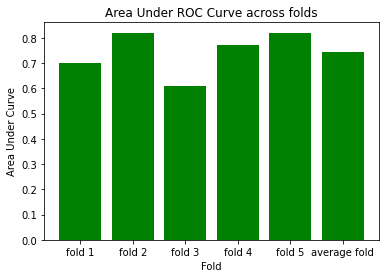

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

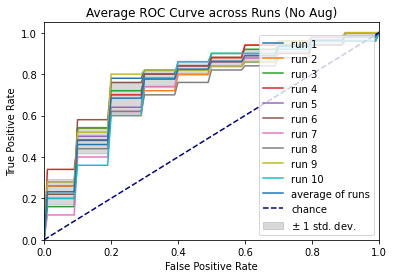

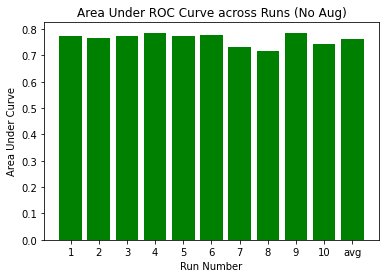

In [ ]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [ ]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7629999999999999, 0.021713004063338297)

In [ ]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [ ]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 
import numpy as np
meta_results = []
meta_results.append("3/3 [==============================] - 0s 143ms/step - loss: 0.5490 - accuracy: 0.7625 - precision_127: 0.7692 - recall_127: 0.7500 - val_loss: 0.6196 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5468 - accuracy: 0.7500 - precision_128: 0.7381 - recall_128: 0.7750 - val_loss: 0.4929 - val_accuracy: 0.7500 - val_precision_128: 0.7778 - val_recall_128: 0.7000")
meta_results.append("3/3 [==============================] - 0s 148ms/step - loss: 0.5195 - accuracy: 0.7875 - precision_129: 0.8485 - recall_129: 0.7000 - val_loss: 0.6768 - val_accuracy: 0.6500 - val_precision_129: 0.7143 - val_recall_129: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5528 - accuracy: 0.7375 - precision_130: 0.8800 - recall_130: 0.5500 - val_loss: 0.6188 - val_accuracy: 0.7000 - val_precision_130: 0.7500 - val_recall_130: 0.6000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5276 - accuracy: 0.7500 - precision_131: 0.7500 - recall_131: 0.7500 - val_loss: 0.5546 - val_accuracy: 0.7500 - val_precision_131: 0.7778 - val_recall_131: 0.7000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.3641 - accuracy: 0.8250 - precision_133: 0.9333 - recall_133: 0.7000 - val_loss: 0.8364 - val_accuracy: 0.7000 - val_precision_133: 0.6429 - val_recall_133: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5302 - accuracy: 0.7750 - precision_134: 0.7750 - recall_134: 0.7750 - val_loss: 0.5209 - val_accuracy: 0.8000 - val_precision_134: 0.8000 - val_recall_134: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5198 - accuracy: 0.7375 - precision_135: 0.7209 - recall_135: 0.7750 - val_loss: 0.6696 - val_accuracy: 0.5500 - val_precision_135: 0.5714 - val_recall_135: 0.4000")
meta_results.append('3/3 [==============================] - 0s 142ms/step - loss: 0.5037 - accuracy: 0.7875 - precision_136: 0.8108 - recall_136: 0.7500 - val_loss: 0.5018 - val_accuracy: 0.7500 - val_precision_136: 0.7273 - val_recall_136: 0.8000')
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.6638 - accuracy: 0.6000 - precision_137: 0.6053 - recall_137: 0.5750 - val_loss: 0.6271 - val_accuracy: 0.6000 - val_precision_137: 0.6250 - val_recall_137: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4704 - accuracy: 0.7875 - precision_139: 0.8485 - recall_139: 0.7000 - val_loss: 0.6656 - val_accuracy: 0.7000 - val_precision_139: 0.6667 - val_recall_139: 0.8000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.6160 - accuracy: 0.6500 - precision_140: 0.6875 - recall_140: 0.5500 - val_loss: 0.5326 - val_accuracy: 0.8500 - val_precision_140: 0.8182 - val_recall_140: 0.9000")
meta_results.append("3/3 [==============================] - 0s 134ms/step - loss: 0.4795 - accuracy: 0.7625 - precision_141: 0.7838 - recall_141: 0.7250 - val_loss: 0.7107 - val_accuracy: 0.6500 - val_precision_141: 0.8000 - val_recall_141: 0.4000")
meta_results.append("3/3 [==============================] - 0s 121ms/step - loss: 0.5433 - accuracy: 0.7375 - precision_142: 0.9130 - recall_142: 0.5250 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_142: 0.7000 - val_recall_142: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.4387 - accuracy: 0.8375 - precision_143: 0.9091 - recall_143: 0.7500 - val_loss: 0.8756 - val_accuracy: 0.7000 - val_precision_143: 0.6429 - val_recall_143: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5071 - accuracy: 0.7750 - precision_145: 0.8235 - recall_145: 0.7000 - val_loss: 0.6108 - val_accuracy: 0.7000 - val_precision_145: 0.6429 - val_recall_145: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4103 - accuracy: 0.7875 - precision_146: 0.7674 - recall_146: 0.8250 - val_loss: 0.6352 - val_accuracy: 0.7500 - val_precision_146: 0.7273 - val_recall_146: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5201 - accuracy: 0.7375 - precision_147: 0.8065 - recall_147: 0.6250 - val_loss: 0.7552 - val_accuracy: 0.5500 - val_precision_147: 0.6000 - val_recall_147: 0.3000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4809 - accuracy: 0.7750 - precision_148: 0.7750 - recall_148: 0.7750 - val_loss: 0.5301 - val_accuracy: 0.7500 - val_precision_148: 0.7273 - val_recall_148: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.6238 - accuracy: 0.7250 - precision_149: 0.6957 - recall_149: 0.8000 - val_loss: 0.5609 - val_accuracy: 0.7000 - val_precision_149: 0.7500 - val_recall_149: 0.6000")
meta_results.append("3/3 [==============================] - 0s 147ms/step - loss: 0.4444 - accuracy: 0.8125 - precision_151: 0.8571 - recall_151: 0.7500 - val_loss: 0.6537 - val_accuracy: 0.7000 - val_precision_151: 0.6667 - val_recall_151: 0.8000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4550 - accuracy: 0.8000 - precision_152: 0.7500 - recall_152: 0.9000 - val_loss: 0.6105 - val_accuracy: 0.7500 - val_precision_152: 0.7778 - val_recall_152: 0.7000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.4810 - accuracy: 0.7625 - precision_153: 0.8000 - recall_153: 0.7000 - val_loss: 0.6956 - val_accuracy: 0.6500 - val_precision_153: 0.7143 - val_recall_153: 0.5000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.4951 - accuracy: 0.7625 - precision_154: 0.7692 - recall_154: 0.7500 - val_loss: 0.5621 - val_accuracy: 0.7500 - val_precision_154: 0.7273 - val_recall_154: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_155: 0.8421 - recall_155: 0.8000 - val_loss: 0.5144 - val_accuracy: 0.7500 - val_precision_155: 0.7778 - val_recall_155: 0.7000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.5146 - accuracy: 0.7375 - precision_157: 0.7568 - recall_157: 0.7000 - val_loss: 0.6470 - val_accuracy: 0.7000 - val_precision_157: 0.6429 - val_recall_157: 0.9000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5297 - accuracy: 0.7750 - precision_158: 0.7895 - recall_158: 0.7500 - val_loss: 0.5801 - val_accuracy: 0.7500 - val_precision_158: 0.7778 - val_recall_158: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4522 - accuracy: 0.7750 - precision_159: 0.8056 - recall_159: 0.7250 - val_loss: 0.6115 - val_accuracy: 0.6000 - val_precision_159: 0.7500 - val_recall_159: 0.3000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.5559 - accuracy: 0.7250 - precision_160: 0.6957 - recall_160: 0.8000 - val_loss: 0.5596 - val_accuracy: 0.7000 - val_precision_160: 0.6667 - val_recall_160: 0.8000")
meta_results.append("3/3 [==============================] - 0s 175ms/step - loss: 0.5519 - accuracy: 0.7750 - precision_161: 0.8438 - recall_161: 0.6750 - val_loss: 0.5466 - val_accuracy: 0.6500 - val_precision_161: 0.7143 - val_recall_161: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4980 - accuracy: 0.7750 - precision_163: 0.8235 - recall_163: 0.7000 - val_loss: 0.6757 - val_accuracy: 0.6500 - val_precision_163: 0.6154 - val_recall_163: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4898 - accuracy: 0.7750 - precision_164: 0.7895 - recall_164: 0.7500 - val_loss: 0.6056 - val_accuracy: 0.7000 - val_precision_164: 0.7000 - val_recall_164: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.5320 - accuracy: 0.7375 - precision_165: 0.7209 - recall_165: 0.7750 - val_loss: 0.7340 - val_accuracy: 0.6500 - val_precision_165: 0.6364 - val_recall_165: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4484 - accuracy: 0.7750 - precision_166: 0.7895 - recall_166: 0.7500 - val_loss: 0.5302 - val_accuracy: 0.7500 - val_precision_166: 0.7273 - val_recall_166: 0.8000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6792 - accuracy: 0.6750 - precision_167: 0.6522 - recall_167: 0.7500 - val_loss: 0.6917 - val_accuracy: 0.5500 - val_precision_167: 0.5556 - val_recall_167: 0.5000")
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.4365 - accuracy: 0.8125 - precision_169: 0.8788 - recall_169: 0.7250 - val_loss: 0.7150 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5207 - accuracy: 0.7750 - precision_170: 0.7750 - recall_170: 0.7750 - val_loss: 0.5656 - val_accuracy: 0.7500 - val_precision_170: 0.7778 - val_recall_170: 0.7000")
meta_results.append("3/3 [==============================] - 0s 131ms/step - loss: 0.4846 - accuracy: 0.7625 - precision_171: 0.7692 - recall_171: 0.7500 - val_loss: 0.7023 - val_accuracy: 0.6500 - val_precision_171: 0.6667 - val_recall_171: 0.6000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_172: 0.8824 - recall_172: 0.7500 - val_loss: 0.8445 - val_accuracy: 0.7000 - val_precision_172: 0.7500 - val_recall_172: 0.6000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.6846 - accuracy: 0.5750 - precision_173: 0.5682 - recall_173: 0.6250 - val_loss: 0.6460 - val_accuracy: 0.6000 - val_precision_173: 0.6250 - val_recall_173: 0.5000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4731 - accuracy: 0.7625 - precision_175: 0.7838 - recall_175: 0.7250 - val_loss: 0.6003 - val_accuracy: 0.7500 - val_precision_175: 0.6923 - val_recall_175: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.6343 - accuracy: 0.6875 - precision_176: 0.6744 - recall_176: 0.7250 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_176: 1.0000 - val_recall_176: 0.4000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6491 - accuracy: 0.5875 - precision_177: 0.6061 - recall_177: 0.5000 - val_loss: 0.6270 - val_accuracy: 0.6000 - val_precision_177: 1.0000 - val_recall_177: 0.2000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4416 - accuracy: 0.8000 - precision_178: 0.8333 - recall_178: 0.7500 - val_loss: 0.6544 - val_accuracy: 0.6500 - val_precision_178: 0.7143 - val_recall_178: 0.5000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4658 - accuracy: 0.8125 - precision_179: 0.9032 - recall_179: 0.7000 - val_loss: 0.6116 - val_accuracy: 0.7500 - val_precision_179: 0.7778 - val_recall_179: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4735 - accuracy: 0.8000 - precision_181: 0.8750 - recall_181: 0.7000 - val_loss: 0.6479 - val_accuracy: 0.6500 - val_precision_181: 0.6667 - val_recall_181: 0.6000")
meta_results.append("3/3 [==============================] - 0s 153ms/step - loss: 0.5056 - accuracy: 0.7750 - precision_182: 0.7895 - recall_182: 0.7500 - val_loss: 0.4801 - val_accuracy: 0.7500 - val_precision_182: 0.7778 - val_recall_182: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4631 - accuracy: 0.8000 - precision_183: 0.8000 - recall_183: 0.8000 - val_loss: 0.7841 - val_accuracy: 0.5000 - val_precision_183: 0.5000 - val_recall_183: 0.3000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4344 - accuracy: 0.8500 - precision_184: 0.8684 - recall_184: 0.8250 - val_loss: 0.6026 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.5167 - accuracy: 0.7375 - precision_185: 0.7111 - recall_185: 0.8000 - val_loss: 0.5716 - val_accuracy: 0.7000 - val_precision_185: 0.7500 - val_recall_185: 0.6000")

METRICS = [interpret(result) for result in meta_results]

In [ ]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [ ]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.759 ± 0.058
training precision : 0.785 ± 0.081
training recall : 0.725 ± 0.078
validation accuracy : 0.688 ± 0.068
validation precision : 0.711 ± 0.091
validation recall : 0.658 ± 0.181


In [ ]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.75 ± 0.06
validation F1 : 0.665 ± 0.115


In [ ]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

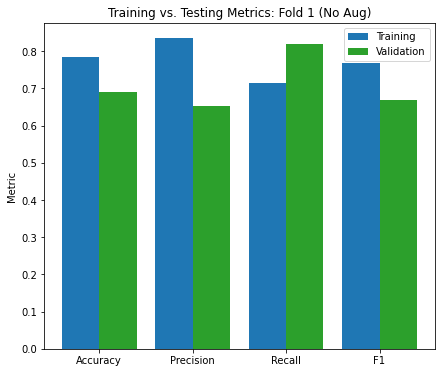

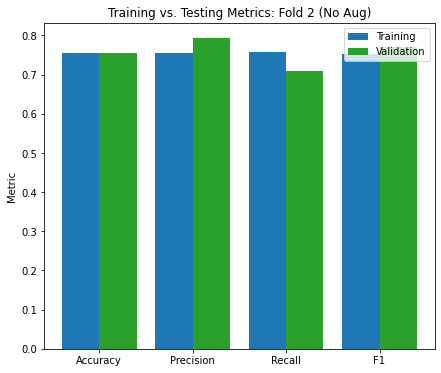

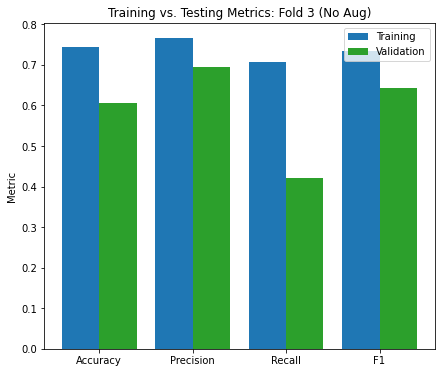

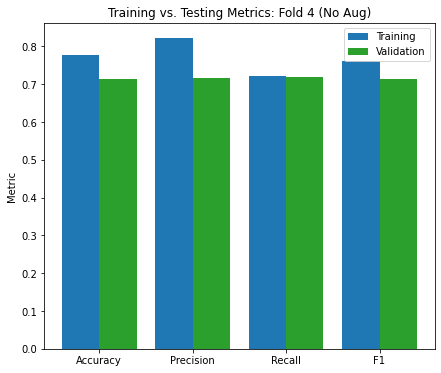

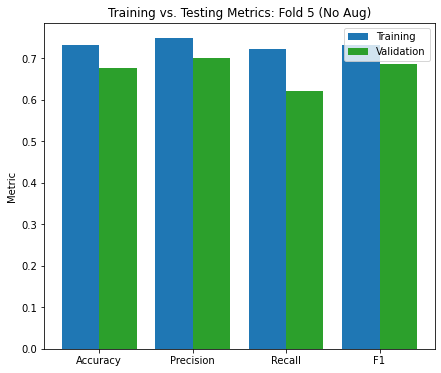

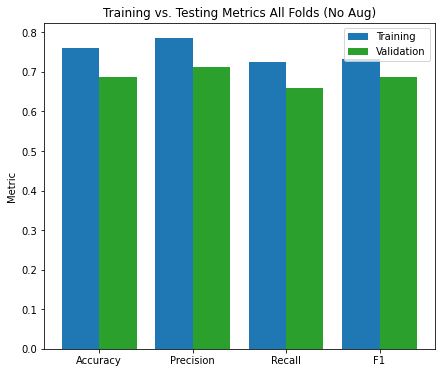

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}_naug.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all_naug.png")
    plt.show()